## Setup

In [1]:
import sys

sys.path.insert(0, 'backend_functions')

import selection_functions as sf

import importlib

import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb

import awkward
import matplotlib.pyplot as plt
import pandas as pd

import ROOT
from ROOT import TH1F, TH2F, TDirectory, TH1D

import top 
from top import *

importlib.reload(sf)
from selection_functions import *


Welcome to JupyROOT 6.18/00


In [2]:
ISRUN3 = False
NUE_INTRINSIC = True

In [3]:
if not ISRUN3:
    import NuMIGeoWeights
    importlib.reload(NuMIGeoWeights)

    # the default option is FHC, RHC needs different arguments - need to create still 
    numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights() 

In [4]:
plots_path = parameters(ISRUN3)['plots_path']

In [5]:
# POT normalization factors


overlay_pot =  parameters(ISRUN3)['overlay_pot']   
dirt_pot = parameters(ISRUN3)['dirt_pot'] 
beamon_pot = parameters(ISRUN3)['beamon_pot'] 


beamon_ntrig =  parameters(ISRUN3)['beamon_ntrig'] 
beamoff_ntrig = parameters(ISRUN3)['beamoff_ntrig'] 
    
if NUE_INTRINSIC: 
    nue_intrinsic_pot = parameters(ISRUN3)['intrinsic_pot'] 


In [6]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

DATA = ""
EXT = ""
OVRLY  = ""
DRT = ""
NUE = ""

# old paths 
# '/uboone/data/users/kmistry/work/MCC9/searchingfornues/'
# path = '/uboone/data/users/kmiller/ntuples/run1/
# path = '/uboone/data/users/kmiller/ntuples/run1/qualcuts/'

path = parameters(ISRUN3)['cv_ntuple_path']
print('path = ', path)

if not ISRUN3: 
    
    #path = '/uboone/data/users/kmiller/uBNuMI_CCNp/ntuples/run1/nuepresel/' # includes shr_energy_tot_cali cut
    
    # Run 1 FHC 
    OVRLY = 'neutrinoselection_filt_run1_overlay_v7'
    EXT = 'neutrinoselection_filt_run1_beamoff_v5'
    DATA = 'neutrinoselection_filt_run1_beamon_beamgood_v5'
    DRT = 'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'
    
    if NUE_INTRINSIC: 
        NUE = 'neutrinoselection_filt_run1_overlay_intrinsic_v7' 


else: 
    
    #path = '/uboone/data/users/kmiller/uBNuMI_CCNp/ntuples/run3b/nuepresel/'
    
    # Run 3 RHC
    OVRLY = 'neutrinoselection_filt_run3b_overlay_v7'
    DATA = 'neutrinoselection_filt_run3b_beamon_beamgood_v5'
    EXT = 'neutrinoselection_filt_run3b_beamoff_v5'
    DRT = 'neutrinoselection_filt_run3b_dirt_overlay_v6'
    
    if NUE_INTRINSIC: 
        NUE = 'neutrinoselection_filt_run3b_overlay_intrinsic_v7'


path =  /uboone/data/users/kmiller/uBNuMI_CCNp/ntuples/run1/cv_slimmed/nuepresel/


In [7]:

overlay = uproot.open(path+OVRLY+".root")[fold][tree]
data = uproot.open(path+DATA+".root")[fold][tree]
ext = uproot.open(path+EXT+".root")[fold][tree]
dirt = uproot.open(path+DRT+".root")[fold][tree]  

uproot_v = [overlay,data,ext,dirt]

if NUE_INTRINSIC: 
    nue = uproot.open(path+NUE+".root")[fold][tree]
    uproot_v.append(nue)


In [8]:
variables = [
    "trk_score_v", 
    "shr_tkfit_dedx_Y", 
    "n_tracks_contained", 
    "NeutrinoEnergy2",
    "run","sub","evt",
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "shrsubclusters0","shrsubclusters1","shrsubclusters2",
    "trkshrhitdist2",
    "n_showers_contained", 
    "shr_phi", "trk_phi", "trk_theta",
    "shr_score", 
    "trk_energy", 
    "tksh_distance", "tksh_angle",
    "shr_energy_tot_cali", "shr_energy_cali", 
    "nslice", 
    "contained_fraction",
    "shrmoliereavg", "shr_px", "shr_py", "shr_pz"
]

# MC only variables
mc_var = ["nu_pdg", "shr_theta", "true_e_visible", "ccnc", 
          "nproton", "nu_purity_from_pfp", "nu_e", "npi0", "npion",
          "true_nu_vtx_x", "true_nu_vtx_y" , "true_nu_vtx_z", 
          "weightTune", "weightSpline", "weightSplineTimesTune", 
          "true_nu_px", "true_nu_py", "true_nu_pz", 
          "elec_e", "proton_e", "mc_px", "mc_py", "mc_pz", "elec_px", "elec_py", "elec_pz", 
          "swtrig_pre", "ppfx_cv", "mc_pdg", "opening_angle"]


## Create pandas dataframes

In [9]:
# OVERLAY 
overlay = overlay.pandas.df(variables + mc_var, flatten=False)

In [10]:
# DIRT 
dirt = dirt.pandas.df(variables + mc_var, flatten=False)

In [11]:
# INTRINSIC 
if NUE_INTRINSIC: 
    nue = nue.pandas.df(variables + mc_var, flatten=False)

In [12]:
# BEAM ON 
data = data.pandas.df(variables, flatten=False) 

In [13]:
# BEAM OFF
ext = ext.pandas.df(variables, flatten=False)

In [15]:
# equalize the columns

for var in mc_var: 
    data[var] = np.nan
    ext[var] = np.nan

In [16]:
# is dirt bool

overlay['isDirt'] = False
dirt['isDirt'] = True

if NUE_INTRINSIC: 
    nue['isDirt'] = False
    
data['isDirt'] = np.nan
ext['isDirt'] = np.nan

In [17]:
# how to get the LLR-PID value for the "track candidate" (proton for nue selection, muon for numu)
# code from Giuseppe!
#LLR-PID : log likelihood ratio particle ID 

df_v = [overlay,data,ext,dirt]

if NUE_INTRINSIC: 
    df_v.append(nue)
    
for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_llr_pid_v = up.array('trk_llr_pid_score_v')
    trk_id = up.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    df['trkpid'] = trk_llr_pid_v_sel
    df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['NeutrinoEnergy2_GeV'] = df['NeutrinoEnergy2']/1000


In [18]:
mc_df = [overlay, dirt]

if NUE_INTRINSIC: 
    mc_df.append(nue)

In [19]:
for i,df in enumerate(mc_df):
    
    # is signal bool 
    df['is_signal'] = np.where((df.swtrig_pre == 1) 
                             & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                             & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    # Add truth level theta & phi angles (detector & beam coordinates)
    df = addAngles(df)


In [20]:
# make dataframes equal # of columns 

data['is_signal'] = np.nan
ext['is_signal'] = False

nan_var = ['thdet', 'phidet', 'true_nu_px_beam', 'true_nu_py_beam', 'true_nu_pz_beam', 
           'thbeam', 'phibeam']

for var in mc_var+nan_var: 
    data[var] = np.nan
    ext[var] = np.nan

In [21]:
# some checks 
print(len(nue.query('is_signal==True'))==len(nue.query(signal)))
print(len(nue.query('is_signal==False'))==len(nue.query(not_signal)))

True
True


## Weights

In [22]:
# clean bad weights & values 

for i,df in enumerate(mc_df):
     
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.  

        

In [23]:
# pot scaling weights 

dirt_tune = parameters(ISRUN3)['dirt_tune']
ext_tune = parameters(ISRUN3)['ext_tune']
    
##############################################
# SCALE TO BEAM ON POT
overlay_scale_to_data = beamon_pot/overlay_pot

if NUE_INTRINSIC: 
    nue_scale_to_data = beamon_pot/nue_intrinsic_pot

dirt_scale_to_data = dirt_tune*(beamon_pot/dirt_pot)
beamoff_scale_to_data = ext_tune*(beamon_ntrig/beamoff_ntrig) # scale factor to beam on POT

overlay['pot_scale'] = overlay_scale_to_data

if NUE_INTRINSIC: 
    nue['pot_scale'] = nue_scale_to_data
    
dirt['pot_scale'] = dirt_scale_to_data
ext['pot_scale'] = beamoff_scale_to_data
data['pot_scale'] = [1 for x in range(len(data))]

##############################################
# SCALE TO OVERLAY

dirt_scale_to_overlay = dirt_tune*(overlay_pot/dirt_pot)
beamoff_scale_to_overlay = ext_tune*((overlay_pot/beamon_pot)*(beamon_ntrig/beamoff_ntrig))

if NUE_INTRINSIC: 
    nue_scale_to_overlay = overlay_pot/nue_intrinsic_pot

overlay['pot_scale_overlay'] = [1 for x in range(len(overlay))]
if NUE_INTRINSIC: 
    nue['pot_scale_overlay'] = nue_scale_to_overlay
    
dirt['pot_scale_overlay'] = dirt_scale_to_overlay
ext['pot_scale_overlay'] = beamoff_scale_to_overlay
data['pot_scale_overlay'] = [1 for x in range(len(data))]


In [24]:
# total weights 

# combined genie * POT weight * flux weight 
# ext gets POT weight only 

################################################################
# totweight_data scales to BEAMON

# tuned
overlay['totweight_data'] = overlay['pot_scale']*overlay['ppfx_cv']*overlay['weightSplineTimesTune']
dirt['totweight_data'] = dirt['pot_scale']*dirt['ppfx_cv']*dirt['weightSplineTimesTune']

if NUE_INTRINSIC: 
    nue['totweight_data'] = nue['pot_scale']*nue['ppfx_cv']*nue['weightSplineTimesTune']


################################################################
# totweight_overlay scales to STANDARD OVERLAY

# tuned
overlay['totweight_overlay'] = overlay['ppfx_cv']*overlay['weightSplineTimesTune']
dirt['totweight_overlay'] = dirt['pot_scale_overlay']*dirt['ppfx_cv']*dirt['weightSplineTimesTune']

if NUE_INTRINSIC:
    nue['totweight_overlay'] = nue['pot_scale_overlay']*nue['ppfx_cv']*nue['weightSplineTimesTune']


In [25]:
# equalize the columns

new_var = ['totweight_data', 'totweight_overlay']

for var in new_var: 
    for df in [data, ext]: 
        df[var] = np.nan

## Categories

In [26]:
if NUE_INTRINSIC: 
    
    # intrinsic sample contains in AV TPC events ONLY, & only CC events (overlay is entire cryo)
    in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
    
    # remove the nue/nuebar CC in overlay
    nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query
    print("# of nueCC in AV in overlay sample = "+str(len(overlay.query(nueCC_query))))
    len1 = len(overlay)
    
    idx = overlay.query(nueCC_query).index
    overlay.drop(idx, inplace=True)
    len2 = len(overlay) 
    print("# of nueCC in AV dropped in overlay = "+str(len1-len2))
    
    # then add in nue_intrinsic 
    overlay = pd.concat([overlay,nue], ignore_index=True)

    # from here on out everything else should be the same. 


# of nueCC in AV in overlay sample = 5675
# of nueCC in AV dropped in overlay = 5675


In [27]:
# combine overlay + dirt as MC 
mc = pd.concat([overlay.query('swtrig_pre==1'),dirt.query('swtrig_pre==1')], ignore_index=True, sort=True)

# separate by in/out FV & cosmic
infv = mc.query(in_fv_query)#+' and nu_purity_from_pfp>0.5')
#cosmic = mc.query(in_fv_query+' and nu_purity_from_pfp<=0.5')
outfv = mc.query(out_fv_query)

In [28]:

# check that everything is accounted for 
print(len(mc)==len(infv)+len(outfv))#+len(cosmic))

if not (len(mc)==len(infv)+len(outfv)): #+len(cosmic)): 
    
    d = len(mc) - (len(infv)+len(outfv))#+len(cosmic))
    print(d)
    
    m = pd.concat([infv, outfv]) #pd.concat([infv, cosmic, outfv])
    diff = np.setdiff1d(list(mc.index),list(m.index))


True


In [29]:
tot_signal_weighted = np.nansum(mc.query('is_signal==True')['totweight_data'])
print('total signal events in FV  = '+ str(tot_signal_weighted))


total signal events in FV  = 244.15144937523092


In [30]:
# 5 main categories: 

# infv - overlay & dirt events with truth vtx in FV 
# outfv - overlay & dirt events with truth vtx in FV that are classified as neutrinos
# cosmic - overlay & dirt events with true vtx in FV that get misclassified as cosmic 
# ext - beam OFF data
# data - beam ON data 


datasets = {
    "infv": infv, 
    "outfv": outfv, 
    #"cosmic": cosmic, 
    "ext": ext, 
    "data": data
}


# Linear selection

In [31]:
# apply preselection 

PRE_QUERY = 'nslice==1' # 
PRE_QUERY += ' and ' + reco_in_fv_query 
PRE_QUERY += ' and contained_fraction>0.9' 
PRE_QUERY += ' and shr_energy_tot_cali>0.07'

PRE_QUERY += ' and n_tracks_contained>0'
PRE_QUERY += ' and trk_energy>0.04' 


In [32]:
# new optimized selection by Kaushal 

SEL_QUERY = PRE_QUERY

SEL_QUERY += ' and shr_score<0.125'
SEL_QUERY += ' and shrmoliereavg < 8'
SEL_QUERY += ' and trkpid<0'

SEL_QUERY += ' and n_showers_contained == 1'
SEL_QUERY += ' and shr_tkfit_dedx_Y<4'

if not ISRUN3: 
    SEL_QUERY += ' and tksh_distance<5'
    # SEL_QUERY += ' and -0.9<tksh_angle<0.8'

else: 
    SEL_QUERY += ' and tksh_distance<4'
    # SEL_QUERY += ' and -0.8<tksh_angle<0.8'

In [33]:
# clean the datasets 

selection_variables = ['nslice', "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "contained_fraction", 
                      'shr_energy_tot_cali', 'n_tracks_contained', 'trk_energy', 'shr_score', 'shrmoliereavg', 'trkpid', 
                      'n_showers_contained', 'shr_tkfit_dedx_Y', 'tksh_distance', 'tksh_angle']

for key in datasets.keys(): 
    
    df = datasets[key].copy()
    
    for column in selection_variables:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    datasets[key] = df

###  Linear Selection Performance

 need to update systematic uncertainties ! 
total selected = 64.53324976424668


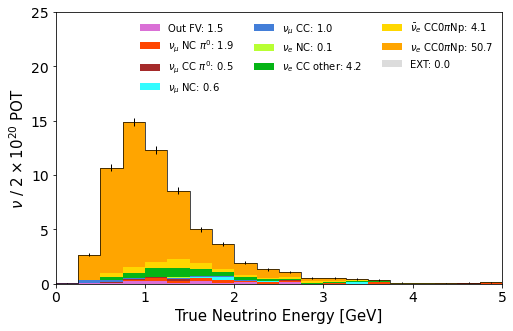

backend_functions/top.py:183: RuntimeWarning: invalid value encountered in double_scalars
  mc_percent_error = [y/z for y, z in zip(mc_total_error, n)]


In [34]:
# event distribution 

x = plot_mc('nu_e', 20, 0, 5, SEL_QUERY, datasets, ISRUN3, norm='data', pot='$2\\times10^{20}$', 
            x_label="True Neutrino Energy [GeV]", save=False, ymax=25)

In [35]:
# list of cuts for selection performance plot 
# updated for modified signal definition

cuts = ['nslice==1',  
        reco_in_fv_query, 
        'contained_fraction>0.9',  
        'shr_energy_tot_cali>0.07', 
        'n_tracks_contained>0',
        'trk_energy>0.04', 
        'shr_score<0.125', 
        'shrmoliereavg<8', 
        'trkpid<0', 
        'n_showers_contained==1', 
        'shr_tkfit_dedx_Y<4']

if not ISRUN3: 
    cuts.append('tksh_distance<5')
    #cuts.append('-0.9<tksh_angle<0.8')

else: 
    cuts.append('tksh_distance<4')
    #cuts.append('-0.8<tksh_angle<0.8')
    
    
cut_names = ['Slice ID', "Reco'd in FV", 'Containment', "Tot. Shr Energy", 
             "# Cont. Tracks","Track Energy", 
             'Shr Score', 'Shr Moliere Angle', 'Trk PID', '# Shrs', 'dE/dx (Y plane)', 
             'Trk/Shr Distance']#, 'Trk/Shr Angle']
    

In [36]:
perf = selection_performance(cuts, datasets, 'totweight_overlay', generated_signal(ISRUN3, 'nu_e', 1, 0, 20), 
                             ISRUN3)
perf

generated_signal scales to standard overlay!
total # of signal generated in FV (normalized to standard overlay): 2852.323722350018
generated_signal scales to standard overlay!
generated_signal scales to standard overlay!
generated_signal scales to standard overlay!
generated_signal scales to standard overlay!


,cut,# signal after cut,efficiency (%),rel. eff. (%),purity (%),"purity (MC only, %)"
0,nslice==1,2852.3,100.0,100.0,NaN,NaN
1,10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_v...,2852.3,100.0,100.0,NaN,NaN
2,reco'd in FV,2852.3,100.0,100.0,NaN,NaN
3,shr_energy_tot_cali>0.07,2852.3,100.0,100.0,NaN,NaN
4,n_tracks_contained>0,2446.1,85.8,85.8,6.9,9.7
5,trk_energy>0.04,2369.3,83.1,96.9,7.0,9.7
6,shr_score<0.125,2161.3,75.8,91.2,9.0,12.0
7,shrmoliereavg<8,1452.2,50.9,67.2,19.3,21.8
8,trkpid<0,1074.3,37.7,74.0,38.3,40.1
9,n_showers_contained==1,915.3,32.1,85.2,55.3,58.6


FIX: error calculation - should use sum of weights squared 
generated_signal scales to standard overlay!
# of generated signal in FV: 2849.487482811938
# of selected signal in FV: 592.4550895014169


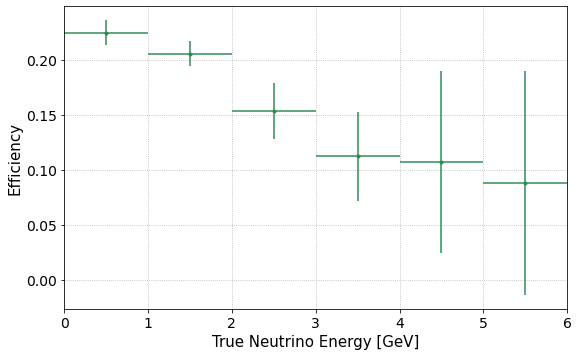

In [37]:
plot_eff('nu_e', 6, 0, 6, SEL_QUERY, datasets, ISRUN3, x_label='True Neutrino Energy [GeV]')

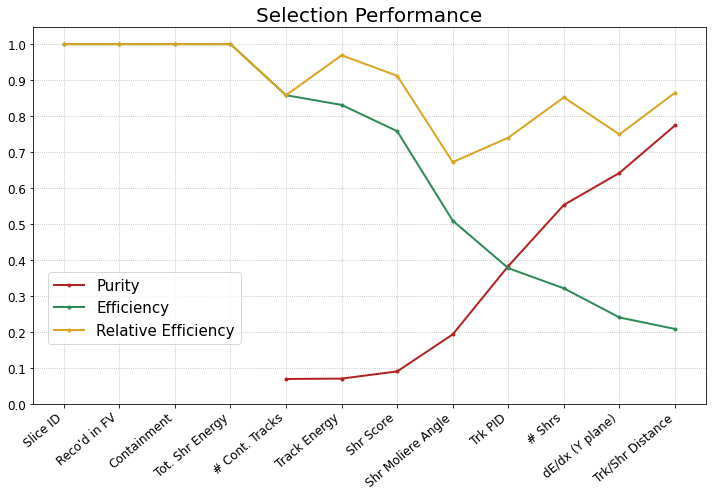

In [38]:
# purity & efficiency as a function of cut 

pur_cut = perf['purity (%)']*.01
eff_cut = perf['efficiency (%)']*.01
rel_eff_cut = perf['rel. eff. (%)']*.01

plt.figure(figsize=(10,7))

plt.plot(list(range(len(pur_cut))), pur_cut, '-o', color='firebrick', 
         label='Purity', markersize=3, linewidth=2)
plt.plot(list(range(len(pur_cut))), eff_cut, '-o', color='seagreen', 
         label='Efficiency', markersize=3, linewidth=2)
plt.plot(list(range(len(pur_cut))), rel_eff_cut, '-o', color='goldenrod', 
         label='Relative Efficiency', markersize=3, linewidth=2)

plt.grid(linestyle=":")

plt.xticks(list(range(12)), cut_names, ha='right', fontsize=12)
plt.xticks(rotation=40)
plt.yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1],  fontsize=12)

plt.legend(bbox_to_anchor=(0.32, 0.37), fontsize=15)

plt.title("Selection Performance", fontsize=20)
plt.tight_layout()
plt.show()

# BDT Selection

In [39]:
# quality cuts
BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'


# signal definition - shower constraints
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'


# signal definition - track constraints
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and trk_energy>0.04' 


In [40]:
BDT_LOOSE_CUTS = BDT_PRE_QUERY

# loose shower constraints
BDT_LOOSE_CUTS +=' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'


# loose track constraints
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [41]:
training_parameters = parameters(ISRUN3)['bdt_training_parameters']

In [ ]:

# load bdt model 
split = 1
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model(parameters(ISRUN3)['bdt_model'])
    
datasets_bdt = {}
training_parameters = parameters(ISRUN3)['bdt_training_parameters']

for i in range(len(datasets)): 

    df = list(datasets.values())[i].copy()
    df = df.query(BDT_LOOSE_CUTS)

    # clean datasets 
    for column in training_parameters:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan

    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[training_parameters])

    # apply the bdt selection
    preds = bdt_model.predict(df_test)

    # add columns for plotting 
    df['BDT_score'] = preds

    datasets_bdt[list(datasets.keys())[i]] = df

In [ ]:
bdt_score_cut = parameters(ISRUN3)['bdt_score_cut']
    
print("BDT SCORE THRESHOLD = "+str(bdt_score_cut))

selected_query = BDT_LOOSE_CUTS + ' and BDT_score>'+str(bdt_score_cut)
selected_signal_query = selected_query + ' and is_signal==True'


In [ ]:
print("GENERATED SIGNAL (DATA NORMALIZED) = "+str(sum(generated_signal(ISRUN3, 'nu_e', 1, 0, 20))*overlay_scale_to_data))


In [ ]:
# BDT score output 

x = plot_mc('BDT_score', 20, 0, 1, '', datasets_bdt, ISRUN3, x_label="BDT Probability Score", 
            norm='data', pot='2$\\times10^{20}$', bdt_scale=split, save=False, ymax=45)

### Performance 

In [ ]:
xvar = 'shr_energy_cali'

xvar_dict = xsec_variables(xvar, ISRUN3)

bins = xvar_dict['bins']
true_var = xvar_dict['true_var']
x_label = xvar_dict['x_label']
beamon_pot = xvar_dict['beamon_pot']
xlow = xvar_dict['xlow']
xhigh = xvar_dict['xhigh']


In [ ]:
x = plot_mc(xvar, bins, xlow, xhigh, 'BDT_score>'+str(bdt_score_cut), datasets_bdt, ISRUN3, 
            norm='data', sys=False, x_label='Reco '+x_label, ymax=60, 
            save=False, save_label="data")

In [ ]:
plot_eff(true_var, bins, xlow, xhigh, 'BDT_score>'+str(bdt_score_cut), datasets_bdt, ISRUN3, 
         x_label=x_label, ymax=0.4, save=False)


## BDT Training

In [42]:
TRAIN = True
save_bdt = True

training_parameters = parameters(ISRUN3)['bdt_training_parameters']

# TRAIN ON A SUBSET OF THE DISTRIBUTION
if TRAIN: 
    BDT_LOOSE_CUTS += ' and -0.9<tksh_angle<0.9'


In [ ]:
# pre-determined boosting round numbers
if not ISRUN3: 
    lc_rounds = 200
    
else: 
    lc_rounds = 200

#test train split 
split = 0.5


In [ ]:
if TRAIN: 

    # BDT training 
    bdt_lc = main_BDT(datasets, BDT_LOOSE_CUTS, lc_rounds, training_parameters, ISRUN3, test_size=split)

    results_df = bdt_lc['bdt_results_df']
    bdt_model = bdt_lc['bdt_model']
    train_df = bdt_lc['df_pre_train']
    test_df = bdt_lc['df_pre_test']
    
    # split events into different categories 
    datasets_bdt = split_events(results_df)

# note: all of the plots following be made with half the POT this way (test/train split)

In [ ]:
if save_bdt: 
    bdt_model.save_model('BDT_models/new_bdt.model')
    print('saving BDT...')

In [ ]:
if TRAIN: 

    # performance of the linear selection for comparison
    gen_num = np.nansum(generated_signal(ISRUN3, xvar, len(bins)-1, bins[0], bins[-1]))*split
    eff_box = np.nansum(test_df.query(SEL_QUERY+' and is_signal==1')['totweight_overlay'])/gen_num * 100

    tot_sel = np.nansum(test_df.query(SEL_QUERY)['weight']) # use weight since EXT does not have totweight_overlay 
    pur_box = np.nansum(test_df.query(SEL_QUERY+' and is_signal==1')['totweight_overlay']) / tot_sel * 100

    results_box = [pur_box, eff_box]

    #  stat errors on the linear performance 
    e = eff_box/100

    eff_err = math.sqrt( (e*(1-e)) / gen_num ) * 100
    pur_err = math.sqrt(np.nansum(test_df.query(SEL_QUERY+' and is_signal==1')['totweight_overlay'])) / tot_sel * 100

    results_box_err = [pur_err, eff_err]

    # x values
    x = np.arange(0, 0.8, 0.025)

    # returns purity, purErr, eff, effErr
    perf_dict = bdt_pe(results_df, x, 
                  np.array(generated_signal(ISRUN3, xvar, len(bins)-1, bins[0], bins[-1])), split)
    pur, pur_err, eff, eff_err = perf_dict['purity'], perf_dict['purErr'], perf_dict['eff'], perf_dict['effErr']
    
    bdt_box_plot([pur, pur_err, eff, eff_err], x, ISRUN3, save=False, results_box=results_box, results_box_err=results_box_err)

In [ ]:
bdt_svb_plot(results_df)

In [ ]:
z = plot_mc('BDT_score', 20, 0, 1, '', datasets_bdt, ISRUN3, x_label="BDT Probability Score", 
            norm='data', pot='2$\\times10^{20}$', save=False, ymax=30, bdt_scale=split)

### Cross validation

In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold

In [ ]:
#mc_weight = 'totweight_data'

splits = 2
repeats = 20
cv = RepeatedStratifiedKFold(n_splits=splits, n_repeats=repeats, random_state=36851234)

bdt_score_arr = np.arange(0, 0.8, 0.025)

q = BDT_LOOSE_CUTS

In [ ]:
df_crossval = addRelevantColumns(datasets)

scale_weight = len(df_crossval.query(q + ' and is_signal == False')) / len(df_crossval.query(q + ' and is_signal == True'))
print("scale pos weight (ratio of negative to positive) = "+str(scale_weight))

In [ ]:
#model params
params = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eta': 0.02,
        'tree_method': 'exact',
        'max_depth': 3,
        'subsample': 0.8,
        'colsample_bytree': 1,
        'silent': 1,
        'min_child_weight': 1,
        'seed': 2002,
        'gamma': 1,
        'max_delta_step': 0,
        'scale_pos_weight': scale_weight,
        'eval_metric': ['error', 'auc', 'aucpr']
}

In [ ]:
final_purity = []
final_efficiency=[]

fp_err = []
fe_err = []

box_pur = []
box_eff = []

boxp_err = []
boxe_err = []

for train_index, test_index in cv.split(df_crossval, df_crossval['is_signal']):
    train, test = df_crossval.iloc[train_index], df_crossval.iloc[test_index]    

    bdt_cv_lc = bdt_raw_results(train, test, BDT_LOOSE_CUTS, training_parameters, params, lc_rounds)
    
    # saves purity, efficiency and respective errors on current test sample for loose cuts BDT
    perf = bdt_pe(bdt_cv_lc[0], bdt_score_arr, 
                  np.array(generated_signal(ISRUN3, xvar, len(bins)-1, bins[0], bins[-1])), split)
    pur, pur_err, eff, eff_err = perf['purity'], perf['purErr'], perf['eff'], perf['effErr']
    
    final_purity.append(pur)
    final_efficiency.append(eff)
    
    fp_err.append(pur_err)
    fe_err.append(eff_err)

    # saves purity and efficiency and respective errors for linear box cut selection performance on current test sample
    sig_sel = sum(test.query(SEL_QUERY+' and is_signal==1')['totweight_overlay'])
    tot_sel = sum(test.query(SEL_QUERY)['weight'])
    tot_sig = sum(generated_signal(ISRUN3, xvar, len(bins)-1, bins[0], bins[-1]))*split
    
    p = sig_sel / tot_sel
    e = sig_sel / tot_sig
    
    box_pur.append(p * 100)
    box_eff.append(e * 100)
    
    boxp_err.append(math.sqrt(sig_sel) / tot_sel * 100)
    boxe_err.append(math.sqrt((e * (1-e)) / tot_sig) * 100)

In [ ]:
# averages results column-wise, which is equivalent to averaging results over the same BDT_score cut

results_bdt = [np.mean(final_purity, axis=0), np.mean(fp_err, axis=0), 
               np.mean(final_efficiency, axis=0), np.mean(fe_err, axis=0)]

# linear box cut selection is a normal average over each distinct test sample
results_box = [np.mean(box_pur), np.mean(box_eff)]
results_box_err = [np.mean(boxp_err), np.mean(boxe_err)]

In [ ]:
for i in range(len(bdt_score_arr)): 
    if bdt_score_arr[i]>=0.45: 
        print("BDT score > "+str(round(bdt_score_arr[i], 3)))
        print("efficiency = "+str(round(results_bdt[2][i], 1)))
        print("purity = "+str(round(results_bdt[0][i], 1)))

In [ ]:
bdt_box_plot(results_bdt, bdt_score_arr, ISRUN3, results_box=results_box, results_box_err=results_box_err, 
           save=False, save_label="FHC_crossval") 

## OUTDATED - Add MC distributions to unfolding file

In [ ]:
# SELECTED MC SIGNAL AS A FUNCTION OF RECO VARIABLE -- SCALES TO DATA

#### background subtracted (to emulate the same process as in data)

d_reco = plot_mc(xvar, bins, xlow, xhigh, 'BDT_score>'+str(bdt_score_cut), datasets_bdt, ISRUN3, 
            norm='data', sys=False, x_label='Reco '+x_label, save=False, plot_bkgd=True)

bincenters = 0.5*(np.array(bins[1:])+np.array(bins[:-1])) # these will be the entries

reco = d_reco['CV'] # signal + background   
bkgd = d_reco['background_counts']

if xsec_units: 
    reco_subtracted = [(i-j)/(n_target*flux) for i,j in zip(reco,bkgd)]
    print(reco_subtracted)

else: 
    reco_subtracted = [i-j for i,j in zip(reco,bkgd)] # background subtracted distribution - these will be the weights  

hreco = TH1D("hmeas", "Selected MC Signal vs. Reco "+x_label+" ("+xvar+")", len(bins)-1, np.array(bins))

for i in range(len(bincenters)): 
    hreco.Fill(bincenters[i], reco_subtracted[i])
    print(bincenters[i], reco_subtracted[i])
 


In [ ]:
# plot hreco 

fig = plt.figure(figsize=(8, 5))

plt.hist(bincenters, bins, histtype='bar', range=[xlow, xhigh], color='orange',  
         weights=reco_subtracted)

plt.xlabel('Reco '+x_label, fontsize=15)
#plt.xlim(0, 3)

plt.title('Selected MC Signal', fontsize=15)


In [ ]:
###########################################################
###########################################################

# BACKGROUND SUBTRACTED, MEASURED DISTRIBUTION (DATA!) - TK 
## hmeas -- replace above with hreco later ##

###########################################################
###########################################################

In [ ]:
importlib.reload(top)
from top import *

In [ ]:
# GENERATED MC SIGNAL AS A FUNCTION OF TRUE VARIABLE -- SCALES TO DATA

htrue_signal_gen = TH1D("htrue_signal", "Generated MC Signal vs. True "+x_label+" ("+true_var+")", len(bins)-1, np.array(bins))

bincenters = 0.5*(np.array(bins[1:])+np.array(bins[:-1])) # these will be the entries
gen = [x*overlay_scale_to_data for x in generated_signal(ISRUN3, true_var, bins, xlow, xhigh)] # these will be the weights - scales to data 

for i in range(len(bincenters)): 
    htrue_signal_gen.Fill(bincenters[i], gen[i])
    # print(bincenters[i], gen[i])

In [ ]:
gen

In [ ]:
htrue_signal_gen

In [ ]:
reco_subtracted

In [ ]:
f = ROOT.TFile.Open("/uboone/data/users/kmiller/unfolding/WSVD_"+xvar+"_FHCRUN1_MARCH12.root", "RECREATE")

In [ ]:
f.cd()

In [ ]:
hreco.Write()
htrue_signal_gen.Write()

In [ ]:
f.Close()

## OUTDATED - DATA/MC Comparisons

In [ ]:
# add BDT model to data

# NOW, apply the model to real data for data/MC comparisons


# apply cuts
data_bdt = data.copy()
data_bdt = data_bdt.query(BDT_LOOSE_CUTS)

# clean datasets 
for column in training_parameters:
        data_bdt.loc[(data_bdt[column] < -1.0e37) | (data_bdt[column] > 1.0e37), column] = np.nan
    
# create testing dmatrix 
data_test = xgb.DMatrix(data=data_bdt[training_parameters])
    
# apply the bdt selection
preds = bdt_model.predict(data_test)

# add columns for plotting 
data_bdt['BDT_score'] = preds

# add to datasets list 
datasets_bdt.append(data_bdt)


#### QUALITY CUTS - out of the box 

In [ ]:
# QUALITY CUTS

### 'nslice==1'
### reco_in_fv_query
### contained_fraction>0.9'

In [ ]:
# nslice

In [ ]:
# reco in FV query 

In [ ]:
h = plt.hist(overlay.query(signal)['contained_fraction'], [round(i*0.1, 1) for i in range(11)],
             weights=overlay.query(signal)['totweight_data'])
plt.show()

h[0]

In [ ]:
importlib.reload(sf)
from selection_functions import plot_data

In [ ]:
sum(overlay.query(signal+' and nu_purity_from_pfp>0.5 and nslice==1 and swtrig_pre==1 and '+in_fv_query)['totweight_data'])

In [ ]:
sum([24373.9, 1658.9, 5283.1, 829.6, 1996.1, 1354.2, 11315.2, 102.4, 312.6, 2825.6, 12669.4, 443.8, 28.7, 320.1])

In [ ]:
# contained fraction - made after nslice & reco in FV query 

x = plot_data('contained_fraction', [round(i*0.1, 1) for i in range(11)], 0, 1, 'nslice==1 and '+reco_in_fv_query, 
              datasets, 
              ISRUN3, x_label="Contained Fraction", sys=False, log=True, ymax=1000000000,
              y_label='$2 \\times 10^{20}$', xtext=0.9, ytext=100000,
              save=False, save_label="NSLICE_FV")

In [ ]:
BDT_PRE_QUERY

In [ ]:
sum(dirt.query(BDT_PRE_QUERY).totweight_data)

#### PRESELECTION VARIABLES - after quality cuts

In [ ]:
# PRESELECTION - FOR THE SIGNAL DEFINITION

### n_tracks_contained>0'
### trk_energy>0.04' # 40 MeV reco pion/proton cut on leading track - what about non-leading tracks?

### n_showers_contained==1'
### shr_energy_tot_cali>0.07'



In [ ]:
# n_tracks_contained>0'

x = plot_data('n_tracks_contained', [i for i in range(8)], 0, 7, '', datasets, 
              ISRUN3, x_label="Contained Tracks", sys=True, 
              y_label='$2 \\times 10^{20}$', xtext=6.7, ytext=7500, ymax=14000, 
              save=True, save_label="QUALCUTS")


In [ ]:
## trk_energy>0.04'

x = plot_data('trk_energy', [i*0.2 for i in range(11)], 0, 2, '', datasets, 
              ISRUN3, x_label="Reconstructed Leading Track Energy [GeV]", sys=True, 
              y_label='$2 \\times 10^{20}$', ymax=12000, xtext=1.9, ytext=6900, 
             save=True, save_label='QUALCUTS')

In [ ]:
# n_showers_contained==1'

x = plot_data('n_showers_contained', [i for i in range(7)], 0, 6, '', datasets, 
              ISRUN3, x_label="Contained Showers", sys=True, 
              y_label='$2 \\times 10^{20}$', xtext=5.7, ytext=9000, ymax=16000, 
             save=True, save_label='QUALCUTS')


In [ ]:
# shr_energy_tot_cali>0.07'

x = plot_data('shr_energy_tot_cali', [i*0.01 for i in range(41)], 0, 0.4, '', datasets, 
              ISRUN3, x_label="Total Calibrated Shower Energy [GeV]", sys=True, 
              y_label='$2 \\times 10^{20}$', log=True, xtext=0.38, ytext=450, 
             save=True, save_label='QUALCUTS')

#### LOOSE CUT VARIABLES - After Preselection Cuts

In [ ]:
# LOOSE CUTS - slimming for BDT training 

### shr_score<0.3'
### shrmoliereavg<15'
### shr_tkfit_dedx_Y<7'

### tksh_distance<12'
### trkpid<0.35'

In [ ]:
importlib.reload(sf)
from selection_functions import *

In [ ]:
# shr_score

x = plot_data('shr_score', [i*0.025 for i in range(21)], 0, 0.5, BDT_PRE_QUERY, datasets, 
              ISRUN3, x_label="Pandora Shower Score", sys=True, 
              y_label='$2 \\times 10^{20}$', xtext=0.48, ytext=375, ymax=650, save=True, save_label='PRESEL')

In [ ]:
# shrmoliereavg

x = plot_data('shrmoliereavg', [i for i in range(31)], 0, 30, 
              BDT_PRE_QUERY, datasets, 
              ISRUN3, x_label="Average Moliere Shower Angle [$\\degree$]", sys=True, 
              y_label='$2 \\times 10^{20}$', ymax=150, xtext=28, ytext=90, save=True, save_label="PRESEL")

In [ ]:
# shr_tkfit_dedx_Y

x = plot_data('shr_tkfit_dedx_Y', [x*0.5 for x in range(25)], 0, 12, 
              BDT_PRE_QUERY, datasets, 
              ISRUN3, x_label="dE/dx on the Y plane [MeV/cm]", 
              sys=True, y_label='$2 \\times 10^{20}$', ymax=320, xtext=11.5, ytext=170, 
              save=True, save_label='PRESEL')

In [ ]:
# tksh_distance

x = plot_data('tksh_distance', [x for x in range(21)], 0, 20, 
              BDT_PRE_QUERY, datasets, 
              ISRUN3, x_label="Distance between track & shower [cm]", 
              sys=True, y_label='$2 \\times 10^{20}$', ymax=250, xtext=19, ytext=140, 
             save=True, save_label='PRESEL')

In [ ]:
# trkpid 

x = plot_data('trkpid', [-1, -0.9, -0.8, -.7, -.6, -.5, -.4, -.3, -.2, -.1, 0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], -1, 1, 
              BDT_PRE_QUERY, datasets, 
              ISRUN3, x_label="Track PID Score", 
              sys=True, y_label='$2 \\times 10^{20}$', ymax=500, xtext=0.8, ytext=275, 
              save=True, save_label="PRESEL")

#### OPENING ANGLE 

In [ ]:
x = plot_data('tksh_angle', [-1, -0.9, -0.8, -.7, -.6, -.5, -.4, -.3, -.2, -.1, 0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1], -1, 1, 
              BDT_LOOSE_CUTS, datasets, 
              ISRUN3, x_label="Reco $cos \\theta_{ep}$", 
              sys=True, y_label='$2 \\times 10^{20}$', ymax=50, xtext=0.85, ytext=28, 
              save=True, save_label="LOOSE_CUTS")

In [ ]:
len()


#### BDT TRAINING VARIABLES - After Preselection & Loose Cuts & Opening Angle cut

In [ ]:
### tksh_angle

# BDT TRAINING VARIABLES 

### shr score (already shown )
### shrmoliereavg (already shown)
### shr_tkfit_dedx_Y (already shown)
### subcluster

### trkpid (already shown)
### tksh_distance (already shown)
### trkshrhitdist2


In [ ]:
### shr score (already shown )
#x = plot_data('shr_score', [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275,0.3], 0, 0.3, 
#              BDT_LOOSE_CUTS+' and -0.9<tksh_angle<0.9', datasets, 
#              ISRUN3, x_label="Pandora Shower Score", sys=False, 
#              y_label='$2 \\times 10^{20}$', xtext=0.29, ytext=90, ymax=160)


In [ ]:
### shrmoliereavg (already shown)
#x = plot_data('shrmoliereavg', [i for i in range(16)], 0, 15, 
#              BDT_LOOSE_CUTS+' and -0.9<tksh_angle<0.9', datasets, 
#              ISRUN3, x_label="Average Moliere Shower Angle [$\\degree$]", sys=False, 
#              y_label='$2 \\times 10^{20}$', ymax=60, xtext=14.5, ytext=33)

In [ ]:
### shr_tkfit_dedx_Y (already shown)
#x = plot_data('shr_tkfit_dedx_Y', [x*0.5 for x in range(15)], 0, 7, 
#              BDT_LOOSE_CUTS+' and -0.9<tksh_angle<0.9', datasets, 
#              ISRUN3, x_label="dE/dx on the Y plane [MeV/cm]", 
#              sys=False, y_label='$2 \\times 10^{20}$', ymax=100, xtext=6.7, ytext=55)

In [ ]:
x = plot_data('subcluster', [5*x for x in range(11)], 0, 50, 
              BDT_LOOSE_CUTS+' and -0.9<tksh_angle<0.9', datasets, 
              ISRUN3, x_label="Number of Shower Subclusters", 
              sys=True, y_label='$2 \\times 10^{20}$', ymax=130, xtext=47, ytext=75, save=True, save_label='LOOSE_CUTS')

In [ ]:
#x = plot_data('trkpid', 10, 0, 1, 
#              BDT_LOOSE_CUTS+' and -0.9<tksh_angle<0.9', datasets, 
#              ISRUN3, x_label="Track PID Score", 
#              sys=False, y_label='$2 \\times 10^{20}$', ymax=50, xtext=0.34, ytext=29)

In [ ]:
x = plot_data('trkshrhitdist2', [x for x in range(9)], 0, 8, 
              BDT_LOOSE_CUTS+' and -0.9<tksh_angle<0.9', datasets, 
              ISRUN3, x_label="2D Distance Between track & shower [cm]", 
              sys=True, y_label='$2 \\times 10^{20}$', ymax=190, xtext=7.5, ytext=110, save=True, save_label='LOOSE_CUTS')

In [ ]:
### already shown 
#x = plot_data('tksh_distance', [x for x in range(13)], 0, 12, 
#              BDT_LOOSE_CUTS+' and -0.9<tksh_angle<0.9', datasets, 
#              ISRUN3, x_label="Distance between track & shower [cm]", 
#              sys=False, y_label='$2 \\times 10^{20}$', ymax=120, xtext=11.5, ytext=68, 
#             save=False, save_label='LOOSE_CUTS')

#### After Training

In [ ]:
# BDT SCORE OUTPUT

x = plot_data('BDT_score', [round(i*0.1,1) for i in range(10)], 0, 0.9, '', datasets_bdt, ISRUN3,
          x_label="BDT Probability Score", sys=False, ymax=105, xtext=0.84, ytext=60, y_label='$2 \\times 10^{20}$', save=True, 
             save_label='BDT_SCORE_DATA')

In [ ]:
x = plot_data(xvar, bins, bins[0], bins[-1], 'BDT_score>'+str(bdt_score_cut), datasets_bdt, ISRUN3,
          x_label='Reco '+x_label, sys=True, y_label='$2 \\times 10^{20}$', ymax=60, save=True, save_label='BDTcut_MCONLY')

In [ ]:
bins = [0.09, 0.4, 0.65, 1, 3]
fine_bins = [0.09, .2, .3, .4, .5, .65, .75, .85, 1.0, 1.5, 2, 2.5, 3]
xvar = "shr_energy_cali"
true_var = "elec_e"
x_label = "Electron Energy [GeV]" #"Shower Energy [GeV]"
data_pot = "$2.0\\times10^{20}$ POT"
xlow = 0.09
xhigh = 3

In [ ]:
BDT_LOOSE_CUTS

In [ ]:
importlib.reload(uncertainty_functions)
from uncertainty_functions import *

In [ ]:
importlib.reload(sf)
from selection_functions import *

In [ ]:
bkgdonly=calcSysError('BDT_score', [round(i*0.1,1) for i in range(10)], 0, 0.9, BDT_LOOSE_CUTS, 
                                       datasets_bdt, 'weightsGenie', 600, ISRUN3, plot=True, background_only=True)

In [ ]:
# DATA / MC -- after preselection cuts 
# slice purity, nslice, reco FV, containment, total shower energy 

q = ''

x = plot_data('reco_nu_vtx_sce_x', 30, 0, 250, q,  datasets, ISRUN3, ymax=350,
          x_label="Reconstructed Interaction Vertex (X) [cm]", xtext=240, ytext=200, sys=False)

x = plot_data('reco_nu_vtx_sce_y', 30, -110, 110, q,  datasets, ISRUN3, ymax=325,
          x_label="Reconstructed Interaction Vertex (Y) [cm]", xtext=-40, ytext=185, sys=False)

x = plot_data('reco_nu_vtx_sce_z', 30, 0, 1000, q,  datasets, ISRUN3, ymax=325,
          x_label="Reconstructed Interaction Vertex (z) [cm]", xtext=300, ytext=195, sys=False)


In [ ]:
x = plot_data('n_showers_contained', 5, 0, 5, q, datasets, ISRUN3, x_label="Number of Showers", ymax=4000, 
         xtext=4.8, ytext=2250, sys=False)

x = plot_data('n_tracks_contained', 7, 0, 7, q, datasets, ISRUN3, x_label='Number of Tracks', ymax=2500, 
         xtext=6.5, ytext=1450, sys=False)

In [ ]:
x = plot_data('shr_energy_tot_cali', 5, 0, 5, q, datasets, ISRUN3, x_label='Total Calibrated Shower Energy [GeV]', ymax=6000, sys=False) 
x = plot_data('trkpid', 20, -1, 1, q, datasets, ISRUN3, x_label='Track PID Score', sys=False) 
x = plot_data('shr_score', 15, 0, .5, q, datasets, ISRUN3, x_label='Pandora Leading Shower Score', sys=False) 

In [ ]:
# after BDT preselection 

#shower score 
#trk PID
#shrmoliereavg 
#shr_tkfit_dedx_Y
#tksh_distance

q = BDT_PRE_QUERY

x = plot_data('shr_score', 10, 0, .5, q, datasets, ISRUN3, x_label='Pandora Leading Shower Score', ymax=1200, sys=False) 
x = plot_data('trkpid', 10, -1, 1, q, datasets, ISRUN3, x_label='Track PID Score', ymax=800) 
x = plot_data('shrmoliereavg', 8, 0, 40, q, datasets, ISRUN3, x_label='Avg Shower Moliere Angle [degrees]', ymax=700)
x = plot_data('shr_tkfit_dedx_Y', 10, 0, 10, q, datasets, ISRUN3, x_label='dE/dx on the Collection Plane [MeV/cm]', ymax=500) 


In [ ]:
# after BDT Loose cuts

#shr_score
#shrmoliereavg 
#trk pid
#n_showers_contained
#subcluster
#trkshrhitdist2

q = BDT_LOOSE_CUTS

x = plot_data('BDT_score', [x/10 for x in range(10)], 0, 0.9, q, datasets_bdt, ISRUN3, 
          norm='pot', ymax=110, x_label='BDT Score', sys=False) 

x = plot_data('shr_score', 10, 0, .3, q, datasets, ISRUN3, x_label='Pandora Leading Shower Score', ymax=300) 
x = plot_data('shrmoliereavg', 5, 0, 15, q, datasets, ISRUN3, x_label='Avg Shower Moliere Angle [degrees]', ymax=175)
x = plot_data('trkpid', 10, -1, .35, q, datasets, ISRUN3, x_label='Track PID Score', ymax=130) 

In [ ]:
# query here?

x = plot_data('BDT_score', [x/10 for x in range(10)], 0, 0.9, '', datasets_bdt, ISRUN3, 
          norm='pot', ymax=110, x_label='BDT Score', sys=False) 


In [ ]:
# after BDT cut - xsec variables

x = plot_data('n_tracks_contained', [1,2,3,7], 1, 7, 'BDT_score>0.55', datasets_bdt, ISRUN3, norm='pot', ymax=100, 
         save=False, save_label='fhc_data_BDT', sys=False, x_label="Contained Tracks") 